<h3>PART 1 </h3>

GENERAL PIPELINE AND PREPARING DATA

In [1]:
import csv
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import os
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util, InputExample, losses, evaluation,  SentencesDataset

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Open the CSV file in read mode
l=[]
# with open("./content/drive/MyDrive/NLP_ASS3_TASK1/train.csv", 'r') as csvfile:
with open("./content/train.csv", 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    # Iterate over each row in the CSV file
    for row in csvreader:
        string=' '.join(row)
        a=string.split("\t")

        if (len(a)!=3):
           pass
        else:
            l.append(a)

train_texts=[]  # List of input sentences
train_scores=[] # List of similarity scores

for a in l:
  if a[0]!="score":
      train_texts.append(a[1]+" [SEP] "+a[2])
      train_scores.append(float(a[0]))






# do the same for validation
l=[]
with open("./content/dev.csv", 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    # Iterate over each row in the CSV file
    for row in csvreader:
        string=' '.join(row)
        a=string.split("\t")

        if (len(a)!=3):
           pass
        else:
            l.append(a)

val_texts=[]  # List of input sentences
val_scores=[] # List of similarity scores

for a in l:
  if a[0]!="score":
      val_texts.append(a[1]+" [SEP] "+a[2])
      val_scores.append(float(a[0]))

# train_texts, val_texts, train_scores, val_scores = train_test_split(texts, scores, test_size=0.2, random_state=42)

In [2]:
def plot_losses(train_losses,val_losses):
    # Plotting
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    plt.title('Loss Plot: Training and Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()





def trainer_and_validator(gpu="T",train_dataloader=None,val_dataloader=None,network=None,criterion=None,optimizer=None,num_epochs=5,checkpoint_dir=""):
     device = (torch.device("cuda:0") if torch.cuda.is_available() else 'mps') if gpu == "T" else torch.device("cpu")
     network.to(device)
     os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)

     train_losses=[]
     val_losses=[]

     for epoch in range(num_epochs):

          network.train()
          total_train_loss = 0
          for batch in train_dataloader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['labels'].to(device)

              optimizer.zero_grad()
              outputs = network(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
              loss = outputs.loss
              total_train_loss += loss.item()
              loss.backward()
              optimizer.step()

          avg_train_loss = total_train_loss / len(train_dataloader)
          train_losses.append(avg_train_loss)




          network.eval()
          total_val_loss=0
          predictions = []
          true_labels = []
          with torch.no_grad():
              for batch in val_dataloader:
                  input_ids = batch['input_ids'].to(device)
                  attention_mask = batch['attention_mask'].to(device)
                  labels = batch['labels'].to(device)

                  outputs = network(input_ids=input_ids, attention_mask=attention_mask)
                  preds = outputs.logits.squeeze().detach().cpu().numpy()
                  predictions.extend(preds)
                  true_labels.extend(labels.cpu().numpy())


          val_loss = mean_squared_error(true_labels, predictions) # mse loss
          val_losses.append(val_loss)
          correlation, p_value = pearsonr(true_labels, predictions)

          print(f'Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}; Average Validation Loss: {val_loss:.4f} Pearson Coefficent: {correlation}')



     #creating plots
     plot_losses(train_losses,val_losses)

     # Saving checkpoints
     torch.save({
              'model_state_dict': network.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
        }, checkpoint_dir+f'last_checkpoint.pt')




# write code for evaluator
def evaluator(gpu="T",network=None,criterion=None,tokenizer=None,checkpoint_dir="",setup=""):
    device = (torch.device("cuda:0") if torch.cuda.is_available() else 'mps') if gpu == "T" else torch.device("cpu")
    if setup=="1A":
        checkpoint=torch.load(checkpoint_dir+f"last_checkpoint.pt")
        model_name = 'google/bert_uncased_L-12_H-768_A-12'
        network = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)
        network.load_state_dict(checkpoint['model_state_dict'])
        network.to(device)

    elif setup=="1C":
         checkpoint=checkpoint_dir+"895/"
         network = SentenceTransformer(checkpoint)



    l=[]
    test_sentences1=[]
    test_sentences2=[]
    # with open("./content/drive/MyDrive/NLP_ASS3_TASK1/sample_test.csv", 'r') as csvfile:
    with open("./content/test_group_41.csv", 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        # Iterate over each row in the CSV file
        for row in csvreader:
            string=' '.join(row)
            a=string.split("\t")

            if (len(a)!=3):
              pass
            else:
                l.append(a)
    test_texts=[]  # List of input sentencess
    original_pairs=[]
    for a in l:
      if a[0]!="id":
          test_texts.append(a[1]+" [SEP] "+a[2])
          original_pairs.append((a[0],a[1],a[2]))
          test_sentences1.append(a[1])
          test_sentences2.append(a[2])


    # Tokenize the new sentences
    if setup=="1A":
        tokenized_inputs = tokenizer(test_texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        input_ids = tokenized_inputs['input_ids'].to(device)
        attention_mask = tokenized_inputs['attention_mask'].to(device)
        with torch.no_grad():
            outputs = network(input_ids=input_ids, attention_mask=attention_mask)
            predicted_scores = outputs.logits.squeeze().tolist()


    elif setup=="1C":
          with torch.no_grad():
              test_embeddings1 = network.encode(test_sentences1)
              test_embeddings2 = network.encode(test_sentences2)
              cos_similarities = [util.cos_sim(embedding1.reshape(1, -1), embedding2.reshape(1, -1)).item()*5 for embedding1, embedding2 in zip(test_embeddings1, test_embeddings2)]
              predicted_scores=cos_similarities


    csv_dataset = pd.DataFrame(list(zip([idx for idx, _, _ in original_pairs], predicted_scores, test_sentences1, test_sentences2)), columns=["idx", "score", "sentence1", "sentence2"])
    csv_dataset.to_csv(f"./content/sample_demo_{setup}.csv", sep='\t', index=False)

SETUP 1A

In [5]:
class TextSimilarityDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, max_len=128):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        score = float(self.scores[idx])
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(score, dtype=torch.float)
        }



# create model
model_name = 'google/bert_uncased_L-12_H-768_A-12'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

# Create datsets
# train_dataset = TextSimilarityDataset(train_texts, train_scores, tokenizer)
# val_dataset = TextSimilarityDataset(val_texts, val_scores, tokenizer)


# set params
num_epochs = 5
batch_size = 32
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.MSELoss()


# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)



# trainer_and_validator(
#     gpu='T',
#     train_dataloader=train_loader,
#     val_dataloader=val_loader,
#     network=model,
#     criterion=None,
#     optimizer=optimizer,
#     num_epochs=num_epochs,
#     checkpoint_dir="./checkpoints/Setup_1A/"
# )



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SETUP 1B

In [5]:
# Load pre-trained Sentence-BERT model
model_name = 'bert-base-nli-mean-tokens'  # You can use other pre-trained models as well
model = SentenceTransformer(model_name)


# Encode validation set sentences to obtain their embeddings
sentence_pairs = [pair.split("[SEP]") for pair in val_texts]
encoded_pairs = [model.encode(pair, convert_to_tensor=True) for pair in sentence_pairs]

# Calculate cosine similarity between embeddings
cos_similarities = [util.pytorch_cos_sim(pair[0].unsqueeze(0), pair[1].unsqueeze(0)).item() for pair in encoded_pairs]

# Compute Pearson correlation coefficient between true scores and cosine similarities
pearson_corr, _ = pearsonr(np.array(val_scores)/5, cos_similarities)
print("pearson's coefficient is ", pearson_corr)


pearson's coefficient is  0.7911763839980281


SETUP 1C

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Iteration:   0%|          | 0/179 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/5, Average Training Loss: 0.0203; Average Validation Loss: 0.0303 Pearson Coefficent: 0.8470924253065254


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 2/5, Average Training Loss: 0.0106; Average Validation Loss: 0.0272 Pearson Coefficent: 0.8560576239916355


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 3/5, Average Training Loss: 0.0073; Average Validation Loss: 0.0270 Pearson Coefficent: 0.8559426136401477


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 4/5, Average Training Loss: 0.0059; Average Validation Loss: 0.0268 Pearson Coefficent: 0.8567393242617638


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 5/5, Average Training Loss: 0.0054; Average Validation Loss: 0.0267 Pearson Coefficent: 0.8570701032849466


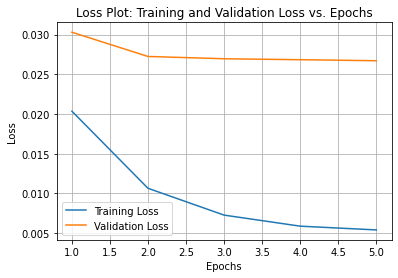

In [6]:
model_name="distilbert-base-nli-mean-tokens"
model = SentenceTransformer("distilbert-base-nli-mean-tokens")
checkpoint_dir="./checkpoints/Setup_1C/"
os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)


train_examples = []
train_sentences1=[]
train_sentences2=[]
for idx,a in enumerate(train_texts):
    l=a.split(" [SEP] ")
    sentence1=l[0]
    sentence2=l[1]
    train_examples.append(InputExample(texts=[sentence1,sentence2],label=train_scores[idx]/5))
    train_sentences1.append(sentence1)
    train_sentences2.append(sentence2)


val_sentences1=[]
val_sentences2=[]
for idx,a in enumerate(val_texts):
    l=a.split(" [SEP] ")
    sentence1=l[0]
    sentence2=l[1]
    val_sentences1.append(sentence1)
    val_sentences2.append(sentence2)



# Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, batch_size=32, shuffle=True)
train_loss = losses.CosineSimilarityLoss(model)

# model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=100,checkpoint_path=checkpoint_dir,checkpoint_save_steps=len(train_dataloader))

train_scores=np.array(train_scores)/5
val_scores=np.array(val_scores)/5
train_losses = []
val_losses=[]

# Tune the model
# for epoch in range(5):  # Adjust as needed
#     model = SentenceTransformer(checkpoint_dir+f"{len(train_dataloader)*(epoch+1)}/")
#     # model.train()
#     # total_train_loss = 0.0
#     # for batch in train_dataloader:
#     #     curr_train_texts,curr_train_scores=batch

#     #     embeddings = model.encode(batch.texts)
#     #     loss = train_loss(embeddings, batch.label)
#     #     loss.backward()
#     #     model.optimizer.step()
#     #     model.zero_grad()
#     #     total_train_loss += loss.item()

#     # avg_train_loss = total_train_loss / len(train_dataloader)
#     # train_losses.append(avg_train_loss)
#     with torch.no_grad():
#       train_embeddings1 = model.encode(train_sentences1)
#       train_embeddings2 = model.encode(train_sentences2)
#       cos_similarities = [util.cos_sim(embedding1.reshape(1, -1), embedding2.reshape(1, -1)).item() for embedding1, embedding2 in zip(train_embeddings1, train_embeddings2)]

#     train_loss = mean_squared_error(train_scores, cos_similarities)
#     train_losses.append(train_loss)



#     model.eval()
#     with torch.no_grad():
#         val_embeddings1 = model.encode(val_sentences1)
#         val_embeddings2 = model.encode(val_sentences2)
#         cos_similarities = [util.cos_sim(embedding1.reshape(1, -1), embedding2.reshape(1, -1)).item() for embedding1, embedding2 in zip(val_embeddings1, val_embeddings2)]

#     val_loss = mean_squared_error(val_scores, cos_similarities)
#     val_losses.append(val_loss)
#     pearson_corr, _ = pearsonr(np.array(val_scores)/5, cos_similarities)
#     print(f'Epoch {epoch+1}/{num_epochs}, Average Training Loss: {train_loss:.4f}; Average Validation Loss: {val_loss:.4f} Pearson Coefficent: {pearson_corr}')



#creating plots
# plot_losses(train_losses,val_losses)



INFERENCE FILE

In [6]:
evaluator(
    gpu='T',
    network=None,
    tokenizer=tokenizer,
    checkpoint_dir="./checkpoints/Setup_1A/",
    setup="1A"
)

evaluator(
    gpu='T',
    network=None,
    checkpoint_dir="./checkpoints/Setup_1C/",
    setup="1C"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
